In [1]:
import pickle
import numpy as np

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
# Load data from each band (assuming files are named accordingly)
with open('processed_data/pd_on vs hc/delta.pkl', 'rb') as f:
    delta_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/theta.pkl', 'rb') as f:
    theta_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/alpha.pkl', 'rb') as f:
    alpha_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/beta.pkl', 'rb') as f:
    beta_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/gamma.pkl', 'rb') as f:
    gamma_data = pickle.load(f)['data']

# Stack the bands along the third dimension
data = np.stack([delta_data, theta_data, alpha_data, beta_data, gamma_data], axis=-1)  # shape: (5580, 32, 5)

In [4]:
import matplotlib.pyplot as plt

In [5]:
data.shape

(5580, 32, 5)

In [6]:
with open('processed_data/pd_on vs hc/delta.pkl', 'rb') as f:
    labels = pickle.load(f)['labels']

In [7]:
import torch
import torch.nn as nn

print(f'Using device: {device}')

# Set device to CUDA if availabledevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using device: mps


In [8]:
from sklearn.preprocessing import StandardScaler

data = data.reshape(-1, data.shape[-2] * data.shape[-1])
scaler = StandardScaler()
data = scaler.fit_transform(data).reshape(-1, 1, 32, 5)

In [9]:
import numpy as np

# Shuffle data and labels together
indices = np.random.permutation(len(data))
data = data[indices]
labels = labels[indices]

In [10]:
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

train_index = 0, int(data.shape[0] * train_ratio)
test_index = train_index[1], int(data.shape[0] * (train_ratio + test_ratio))
val_index = test_index[1], data.shape[0]

data = torch.tensor(data).float().to(device)
labels = torch.tensor(labels).float().to(device)

X_tr, Y_tr = data[train_index[0] :train_index[1]], labels[train_index[0] :train_index[1]]
X_test, Y_test = data[test_index[0] :test_index[1]], labels[test_index[0] :test_index[1]]
X_val, Y_val = data[val_index[0] :val_index[1]], labels[val_index[0] :val_index[1]]

In [11]:
X_tr.shape

torch.Size([3905, 1, 32, 5])

In [59]:
class ConvBlock(nn.Module):
    def __init__(self, in_chans, out_chans):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_chans, out_channels=out_chans, kernel_size=(3, 3), padding=1, stride=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 1)),
            # nn.Dropout(0.2)
            # Dropout removed to allow overfitting for grokking
        )

    def forward(self, x):
        x = self.block(x)
        print(x.shape)
        return x

class ConvReducBlock(nn.Module):
    def __init__(self, in_chans, out_chans):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_chans, out_channels=out_chans, kernel_size=(3, 3), padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            # nn.Dropout(0.2)
            # Dropout removed to allow overfitting for grokking
        )

    def forward(self, x):
        x = self.block(x)
        print(x.shape)
        return x


class ParkinsonsModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.blocks = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(in_chans=32, out_chans=64),
            ConvBlock(in_chans=64, out_chans=128),
            ConvBlock(in_chans=128, out_chans=256),
            ConvBlock(in_chans=256, out_chans=512),
        )

        self.reduc_blocks = nn.Sequential(
            ConvReducBlock(in_chans=512, out_chans=1024),
            ConvReducBlock(in_chans=1024, out_chans=2048),
            ConvReducBlock(in_chans=2048, out_chans=4096),
            ConvReducBlock(in_chans=4096, out_chans=8192),
        )

        self.project = nn.Sequential(
            nn.Flatten(),
            nn.Linear(81920, 64),
            nn.ReLU(),
            # Dropout removed to allow overfitting for grokking
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        print("================================")
        print(f"Input shape: {x.shape}")
        x = self.blocks(x)

        print(f"Pre-reduc shape: {x.shape}")
        x = self.reduc_blocks(x)
        x = self.project(x)

        print(f"Output shape: {x.shape}")
        print("================================")

        return x

In [57]:
model = ParkinsonsModel().to(device)
print(f'Model moved to {device}')
# Weight decay is crucial for grokking - it encourages eventual generalization
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.1,  # Added for grokking
)
print('Optimizer configured with weight_decay=0.1 for grokking')



losses = []
val_accuracies = []
val_losses = []

Model moved to mps
Optimizer configured with weight_decay=0.1 for grokking


In [58]:
BATCH_SIZE = 32

for i in range(5_000_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (32,))
    x, y = X_tr[batch_ix], Y_tr[batch_ix]


    pred = model(x)
    loss = torch.functional.F.binary_cross_entropy(pred, y.view(-1,1))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    with torch.no_grad():
        batch_ix = torch.randint(0, X_val.shape[0], (32,))
        val_pred = model(X_val)
        val_loss = torch.functional.F.binary_cross_entropy(val_pred, Y_val.view(-1,1))
        val_accuracy = ((val_pred > 0.5).float() == Y_val.view(-1,1)).float().mean()
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())

    if i % 100 == 0:
        print(f"epoch: {i}, loss: {loss.item():.3f}, val_loss: {val_loss.item():.3f}, val_acc: {val_accuracy.item():.3f}")

    if i % 50_000 == 0 and i > 0:
        checkpoint = {
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
        }
        torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{i}.pt')
        print(f"Checkpoint saved at epoch {i}")
        
        # Save smoothed plots on single graph with dual y-axes
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Smooth by averaging every 100 epochs
        num_bins = len(losses) // 100
        smoothed_losses = torch.tensor(losses[:num_bins*100]).view(-1, 100).mean(1)
        smoothed_val_losses = torch.tensor(val_losses[:num_bins*100]).view(-1, 100).mean(1)
        smoothed_val_acc = torch.tensor(val_accuracies[:num_bins*100]).view(-1, 100).mean(1)
        
        epochs = range(len(smoothed_losses))
        
        # Plot losses on left y-axis
        ax1.set_xlabel('Epoch (x100)', fontsize=12)
        ax1.set_ylabel('Loss', color='black', fontsize=12)
        line1 = ax1.plot(epochs, smoothed_losses.numpy(), label='Training Loss', color='blue', linewidth=2)
        line2 = ax1.plot(epochs, smoothed_val_losses.numpy(), label='Validation Loss', color='orange', linewidth=2)
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        # Create second y-axis for accuracy
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', color='green', fontsize=12)
        line3 = ax2.plot(epochs, smoothed_val_acc.numpy(), label='Validation Accuracy', color='green', linewidth=2)
        ax2.tick_params(axis='y', labelcolor='green')
        
        # Combine legends from both axes
        lines = line1 + line2 + line3
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best', fontsize=10)
        
        plt.title(f'Training Progress (Epoch {i})', fontsize=14, fontweight='bold')
        plt.tight_layout()

        plt.savefig(f'checkpoints/training_plot_epoch_{i}.png', dpi=150)

        plt.close()        
        print(f"Training plot saved at epoch {i}")

Input shape: torch.Size([32, 1, 32, 5])
torch.Size([32, 32, 32, 5])
torch.Size([32, 64, 32, 5])
torch.Size([32, 128, 32, 5])
torch.Size([32, 256, 32, 5])
torch.Size([32, 512, 32, 5])
Pre-reduc shape: torch.Size([32, 512, 32, 5])
torch.Size([32, 1024, 16, 5])
torch.Size([32, 2048, 8, 5])
torch.Size([32, 4096, 4, 5])
Output shape: torch.Size([32, 1])
Input shape: torch.Size([559, 1, 32, 5])
torch.Size([559, 32, 32, 5])
torch.Size([559, 64, 32, 5])
torch.Size([559, 128, 32, 5])
torch.Size([559, 256, 32, 5])
torch.Size([559, 512, 32, 5])
Pre-reduc shape: torch.Size([559, 512, 32, 5])
torch.Size([559, 1024, 16, 5])
torch.Size([559, 2048, 8, 5])
torch.Size([559, 4096, 4, 5])
Output shape: torch.Size([559, 1])
epoch: 0, loss: 0.696, val_loss: 0.692, val_acc: 0.547
Input shape: torch.Size([32, 1, 32, 5])
torch.Size([32, 32, 32, 5])
torch.Size([32, 64, 32, 5])
torch.Size([32, 128, 32, 5])
torch.Size([32, 256, 32, 5])
torch.Size([32, 512, 32, 5])
Pre-reduc shape: torch.Size([32, 512, 32, 5])
tor

KeyboardInterrupt: 

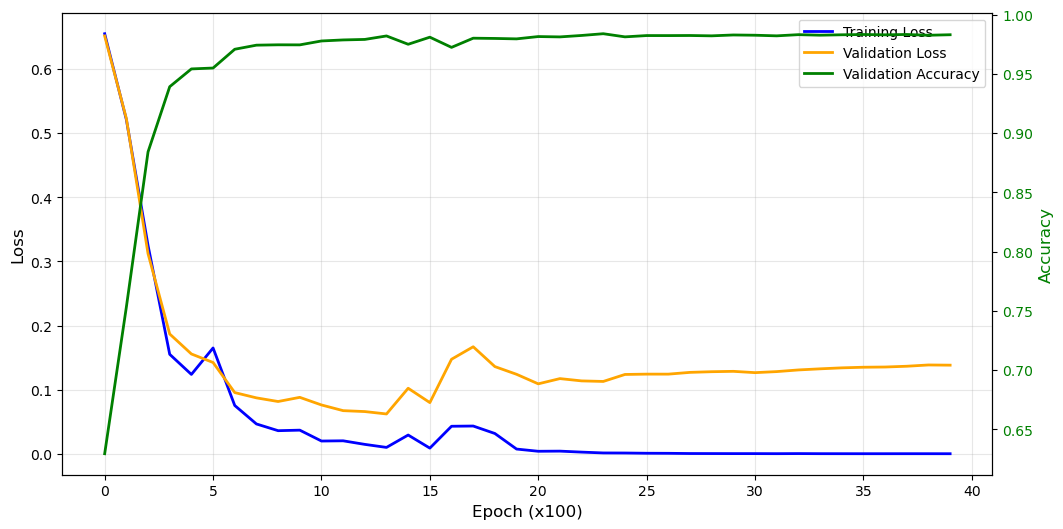

<Figure size 640x480 with 0 Axes>

In [34]:
# Plot all metrics on single graph with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Smooth by averaging every 100 epochs
num_bins = len(losses) // 100
smoothed_losses = torch.tensor(losses[:num_bins*100]).view(-1, 100).mean(1)
smoothed_val_losses = torch.tensor(val_losses[:num_bins*100]).view(-1, 100).mean(1)
smoothed_val_acc = torch.tensor(val_accuracies[:num_bins*100]).view(-1, 100).mean(1)

epochs = range(len(smoothed_losses))

# Plot losses on left y-axis
ax1.set_xlabel('Epoch (x100)', fontsize=12)
ax1.set_ylabel('Loss', color='black', fontsize=12)
line1 = ax1.plot(epochs, smoothed_losses.numpy(), label='Training Loss', color='blue', linewidth=2)
line2 = ax1.plot(epochs, smoothed_val_losses.numpy(), label='Validation Loss', color='orange', linewidth=2)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# Create second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='green', fontsize=12)
line3 = ax2.plot(epochs, smoothed_val_acc.numpy(), label='Validation Accuracy', color='green', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends from both axes
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]

ax1.legend(lines, labels, loc='best', fontsize=10)
plt.show()

plt.tight_layout()

In [122]:
model.eval()
val_losses = []
with torch.no_grad():
    for i in range(1000):
        batch_ix = torch.randint(0, X_val.shape[0], (32,))
        x, y = X_val[batch_ix], Y_val[batch_ix]


        pred = model(x)
        loss = torch.functional.F.binary_cross_entropy(pred, y.view(-1,1))
        val_losses.append(loss.item())

val_loss = torch.tensor(val_losses).mean()
print(f'val loss: {val_loss}')

val loss: 0.08258762955665588


In [103]:
Y_tr.size(), Y_tr.sum()

(torch.Size([3905]), tensor(1888.))

In [123]:
def calculate_metrics(model, X, Y, threshold=0.5):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        predicted_labels = (predictions >= threshold).float()
        
        # Calculate confusion matrix components
        TP = ((predicted_labels == 1) & (Y.view(-1, 1) == 1)).sum().item()
        TN = ((predicted_labels == 0) & (Y.view(-1, 1) == 0)).sum().item()
        FP = ((predicted_labels == 1) & (Y.view(-1, 1) == 0)).sum().item()
        FN = ((predicted_labels == 0) & (Y.view(-1, 1) == 1)).sum().item()
        
        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall, TPR
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # TNR
        
        return {
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'confusion_matrix': {
                'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
            }
        }

# Calculate metrics for validation set
val_metrics = calculate_metrics(model, X_val, Y_val)

print("Validation Metrics:")
print(f"Accuracy:    {val_metrics['accuracy']:.4f}")
print(f"Sensitivity: {val_metrics['sensitivity']:.4f} (ability to detect PD)")
print(f"Specificity: {val_metrics['specificity']:.4f} (ability to detect HC)")
print(f"\nConfusion Matrix:")
print(f"  TP (PD→PD): {val_metrics['confusion_matrix']['TP']}")
print(f"  TN (HC→HC): {val_metrics['confusion_matrix']['TN']}")
print(f"  FP (HC→PD): {val_metrics['confusion_matrix']['FP']}")
print(f"  FN (PD→HC): {val_metrics['confusion_matrix']['FN']}")

Validation Metrics:
Accuracy:    0.9767
Sensitivity: 0.9734 (ability to detect PD)
Specificity: 0.9797 (ability to detect HC)

Confusion Matrix:
  TP (PD→PD): 256
  TN (HC→HC): 290
  FP (HC→PD): 6
  FN (PD→HC): 7


In [ ]:
# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(metrics, title="Confusion Matrix"):
    cm = metrics['confusion_matrix']
    matrix = np.array([[cm['TN'], cm['FP']], 
                       [cm['FN'], cm['TP']]])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_metrics, "Test Set Confusion Matrix")

In [ ]:
# Calculate metrics for test set
test_metrics = calculate_metrics(model, X_test, Y_test)

print("Test Metrics:")
print(f"Accuracy:    {test_metrics['accuracy']:.4f}")
print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TP: {test_metrics['confusion_matrix']['TP']}")
print(f"  TN: {test_metrics['confusion_matrix']['TN']}")
print(f"  FP: {test_metrics['confusion_matrix']['FP']}")
print(f"  FN: {test_metrics['confusion_matrix']['FN']}")

In [33]:
data.reshape(-1, data.shape[-2] * data.shape[-1]).shape

torch.Size([5580, 160])